**Importing the packages**

In [1]:
#from mpmath import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.signal import find_peaks
from scipy.integrate import quad_vec
from time import time
from mpmath import invertlaplace, mp
import matplotlib.animation as animation
from IPython.display import HTML

### In here no equation will be displayed

All calculations were made based in the results presented in:  
[**Universal Algorithm for Simulating and Evaluating Cyclic Voltammetry at Macroporous Electrodes by Considering Random Arrays of Microelectrodes**](https://chemistry-europe.onlinelibrary.wiley.com/doi/full/10.1002/cphc.201901113).

**Defining operator to make inverse Laplace Transform**

We need to have this operation well made, so that all the calculations from now onwards are right

In [2]:
def laplace_transform(I_t, t_vals, s_vals):
    #results = np.zeros_like(s_vals, dtype=np.float64)  # Array to store results

    #for i, s in enumerate(s_vals):
    integral = quad_vec(lambda t: np.interp(t, t_vals, I_t) * np.exp(-s_vals * t), 
                           0, np.max(t_vals))[0]
    results = integral

    return results

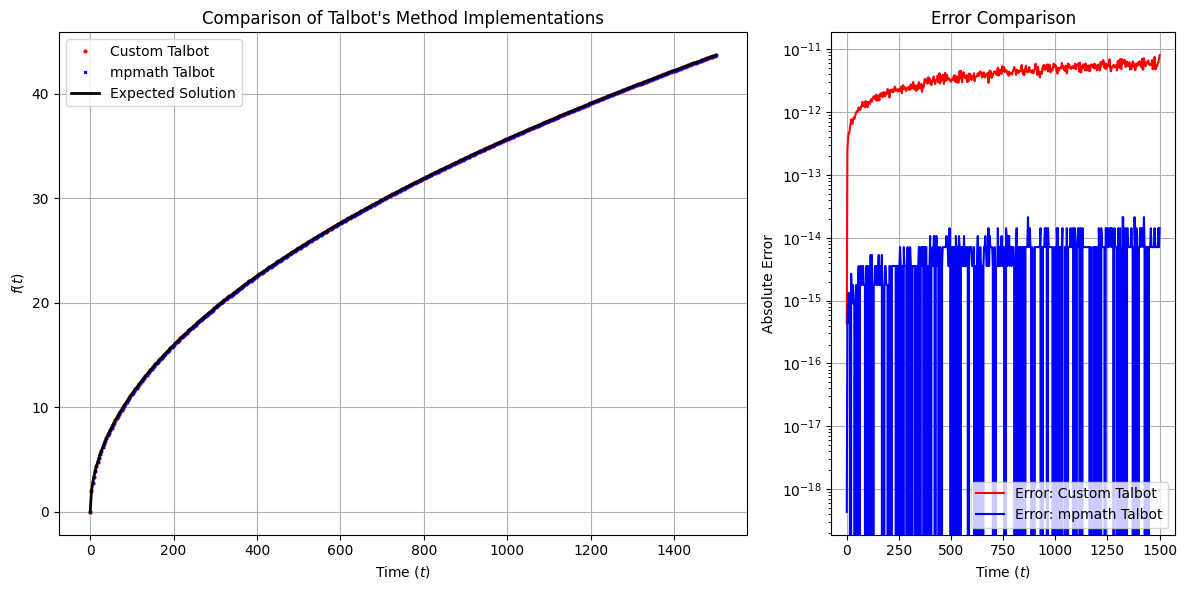

Custom Talbot Execution Time: 0.4911 seconds
mpmath Talbot Execution Time: 2.8310 seconds


In [3]:

def Talbot(F, t_vals, N=40):
    t_vals = np.asarray(t_vals, dtype=np.float64)
    results = np.zeros_like(t_vals, dtype=np.float64)
    h = 2 * np.pi / N
    shift = 0.0

    for idx, t in enumerate(t_vals):
        if t <= 1e-10:
            results[idx] = 0.0
            continue

        ans = 0.0
        for k in range(N):
            theta = -np.pi + (k - 0.5) * h
            cot_term = 1 / np.tan(0.6407 * theta)
            z = shift + (N / t) * (0.5017 * theta * cot_term - 0.6122 + 0.2645j * theta)
            dz = (N / t) * (-0.5017 * 0.6407 * theta / np.sin(0.6407 * theta) ** 2 + 0.5017 * cot_term + 0.2645j)


            if np.isnan(F(z)) or np.isinf(F(z)) or np.isnan(dz) or np.isinf(dz):
                continue

            ans += np.exp(z * t) * F(z) * dz

        results[idx] = (h / (2j * np.pi) * ans).real
    return results

# Define Laplace function
def F(s):
    return 1 / (s ** (3/2))

# Expected solution
def expected_solution(t):
    return 2 * np.sqrt(t) / np.sqrt(np.pi)

# Time values
t_vals = np.linspace(1e-5, 1500, 500)

# Run Talbot's method (Custom)
start = time()
talbot_custom = Talbot(F, t_vals)
custom_time = time() - start

# Run mpmath’s Talbot
mp.dps = 10
start = time()
talbot_mpmath = np.array([invertlaplace(F, t, method='talbot') for t in t_vals], dtype=np.float64)
mpmath_time = time() - start

# Expected
expected_results = expected_solution(t_vals)

# Compute absolute error
error_custom = np.abs(talbot_custom - expected_results)
error_mpmath = np.abs(talbot_mpmath - expected_results)

# Plot results
fig, axs = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [2, 1]})

# Main plot
axs[0].plot(t_vals, talbot_custom, 'o', color='red', markersize=2, label="Custom Talbot")
axs[0].plot(t_vals, talbot_mpmath, 'x', color='blue', markersize=2, label="mpmath Talbot")
axs[0].plot(t_vals, expected_results, 'k-', label="Expected Solution", linewidth=2)
axs[0].set_xlabel("Time ($t$)")
axs[0].set_ylabel("$f(t)$")
axs[0].set_title("Comparison of Talbot's Method Implementations")
axs[0].legend()
axs[0].grid(True)

# Error subplot
axs[1].semilogy(t_vals, error_custom, 'r-', label="Error: Custom Talbot")
axs[1].semilogy(t_vals, error_mpmath, 'b-', label="Error: mpmath Talbot")
axs[1].set_xlabel("Time ($t$)")
axs[1].set_ylabel("Absolute Error")
axs[1].set_title("Error Comparison")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

# Print runtime
print(f"Custom Talbot Execution Time: {custom_time:.4f} seconds")
print(f"mpmath Talbot Execution Time: {mpmath_time:.4f} seconds")

So we are going to use the Talbot fucntion, because it brings a very low incertainty and a high precision

**Defining the Class that does the math for us**

In [165]:
class CVCurrent:
    """   
    This class models the current response in a cyclic voltammetry (CV) experiment, incorporating electrochemical kinetics and diffusion effects.
    It defines key parameters for charge transfer, mass transport, and reaction kinetics, allowing for the calculation of current as a function
    of time and applied potential.

    Attributes:
        Electrode and Reaction Parameters:
            - A (float): Electrode surface area (cm²).
            - F (float): Faraday’s constant (C/mol).
            - R (float): Universal gas constant (J/(mol·K)).
            - T (float): Temperature (K).
            - n (int): Number of electrons transferred in the reaction.
            - c (float): Total concentration of the redox species (mol/cm³).
            - alpha (float): Charge transfer coefficient.
        
        Kinetic and Diffusion Parameters:
            - Kp (float): Ratio of forward (kp) and backward (k_p) reaction rates for a chemical step.
            - Kf (float): Ratio of forward (kf) and backward (k_f) reaction rates for a second chemical step.
            - p (float): Total rate constant for the first chemical reaction (kp + k_p).
            - f (float): Total rate constant for the second chemical reaction (kf + k_f).
            - DO (float): Diffusion coefficient of the oxidized species (cm²/s).
            - DR (float): Diffusion coefficient of the reduced species (cm²/s).
            - km (float): Maximum electron transfer rate constant (1/s).
            - k0 (float): Standard electron transfer rate constant (cm/s).
            - d (float): Characteristic diffusion layer thickness (cm).
    
    Methods:
        - __call__(t, epsilon): Computes the cyclic voltammetry current as a function of time (t) and applied potential (epsilon).
            Uses cubic spline interpolation to evaluate two functions (FuncG and FuncY) over a logarithmic time grid.
            Implements a recursive approach to compute current, incorporating both electron transfer and chemical kinetics.
            The current response is influenced by mass transport effects, reaction kinetics, and charge transfer rates.
        
        - FuncG(t): Placeholder method (to be implemented) for calculating a time-dependent function related to the system dynamics.
        
        - FuncY(t): Placeholder method (to be implemented) for another time-dependent function required for current calculations.
    """


    def __init__(self,kmax = 1e10,c_tot = 0.16,kp = 0.0028,k_p = 0.0015,kf = 0.0008,k_f = 0.0003 ,DO = 3.2e-5,DR =2.7e-5 ,k0 = 2.6*10**(-4), alpha = 0.42 ,A = 28e-4 , F = 96485.3321 , R = 8.314 ,T = 298.15 ,n = 1,d = 0.5 ):
        self.A = A
        self.F = F
        self.R = R
        self.T = T
        self.n = n
        self.c = c_tot
        self.alpha = alpha
        self.Kp = kp/k_p
        self.Kf = kf/k_f
        self.p = kp + k_p
        self.f = kf + k_f
        self.DO = DO
        self.DR = DR
        self.km = kmax
        self.k0 = k0
        self.d = d

    def __call__(self,t,epsilon):
        I = np.zeros(len(t) , dtype=np.float64)
        delta = t[1]-t[0]

         # Generate logarithmic time grid for G and Y
        t_log = np.logspace(-5, 5, 300, dtype = np.float64)  # 300 points from 10^-5 to 10^5
        G_log = self.FuncG(t_log)
        Y_log = self.FuncY(t_log)

        # Create cubic spline interpolators
        G_spline = CubicSpline(t_log, G_log)
        Y_spline = CubicSpline(t_log, Y_log)

        # Interpolate at the desired time points
        G = G_spline(t)
        Y = Y_spline(t)      

        for i in range(len(t)):
            self.update(I, i, t, epsilon, delta, G, Y)

        return I
    
    def update(self, I, i, t, epsilon, delta, G, Y):
        """ Update current I[i] at time index i """
        term1 = self.km / (self.km + self.k0 * np.exp(self.alpha * epsilon[i])) * 1 / (1 + self.Kp)
        term11 = (np.sqrt(self.DR) / self.k0 * np.exp(-self.alpha * epsilon[i]) +
                  (self.km) / (self.km + self.k0 * np.exp(self.alpha * epsilon[i])) * G[0] +
                  (self.km) / (self.km + self.k0 * np.exp(-(1 - self.alpha) * epsilon[i])) *
                  np.sqrt(self.DR / self.DO) * Y[0] * np.exp(-epsilon[i]))

        I0 = self.n * self.F * self.A * self.c * self.Kp * np.sqrt(self.DR)
        term2 = -self.km / (self.km + self.k0 * np.exp(-(1 - self.alpha) * epsilon[i])) * \
                np.exp(-epsilon[i]) / (1 + self.Kf) * (np.sqrt(self.DR / self.DO))

        I1 = 0
        I2 = 0
        for j in range(1, i):
            dY = Y[i - j + 1] - Y[i - j]
            dG = G[i - j + 1] - G[i - j]
            I1 -= I[j] * dG * (self.Kp + np.exp(-delta * self.p * (i - j)))
            I2 += I[j] * dY * (1 + self.Kf * np.exp(-delta * self.f * (i - j)))

        I[i] = ((I0 + I1) * term1 / term11 + term2 / term11 * I2)

    
    def FuncG(t):

        raise NotImplemented
    
    def FuncY(t):

        raise NotImplemented    

In [166]:
class Planar_Semi_Inf(CVCurrent):

    def __init__(self,**kwargs):
        super().__init__(**kwargs)

    def FuncG(self,t):
        GLaplace = lambda s: 1/np.sqrt(s)*(1/s)
        #mp.dps = 10  # Set decimal precision for accuracy

        return Talbot(GLaplace, t , N=40) #np.array([invertlaplace(GLaplace, ti, method='talbot') for ti in t], dtype=np.float64) 
    
    def FuncY(self,t):

        YLaplace = lambda s: 1/np.sqrt(s)*(1/s)
        #mp.dps = 10  # Set decimal precision for accuracy

        return Talbot(YLaplace, t , N=40) #np.array([invertlaplace(YLaplace, ti, method='talbot') for ti in t], dtype=np.float64) #Talbot(YLaplace, t , N=24)

**Let's First try to calculate something we know**

Which is the $\chi$ used in the Randle-Sevick Equation to define the peak of reduction and oxidation current

In [167]:
# Simulating CV Data
c = 0.16
A = 1
F = 96485.3321
R = 8.34
T = 298.15
n = 1
D = 2.7*10**(-5)
kp = 0.0028
k_p = 0.0015
kf = 0.0008
k_f = 0.0003
cv = Planar_Semi_Inf(c_tot = c, A = A , F = F, R = R,DR = D,DO = D , T = T, n =n )

scan_rate = 1e-3
V0 = 0.1
V_in = -0.15

In [168]:
t = np.linspace(2,6e2,400)
epsilon = (V_in + scan_rate*t-V0)*n*F/(R*T)
# Compute current response
I = cv(t, epsilon)

t2 = np.linspace(2,6e2,1000)
epsilon2 = (V_in + scan_rate*t2-V0)*n*F/(R*T)
I2 = cv(t2, epsilon2)

t3 = np.linspace(2,6e2,5000)
epsilon3 = (V_in + scan_rate*t3-V0)*n*F/(R*T)
I3 = cv(t3, epsilon3)

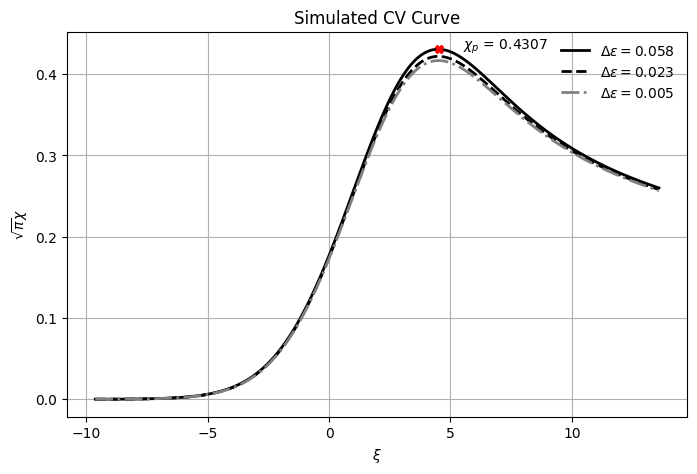

In [169]:
# Plot CV Graph
plt.figure(figsize=(8, 5))
plt.plot(epsilon, np.sqrt(np.pi)*I / (n*F*A*c) * np.sqrt(R*T/(n*F*D*scan_rate)), '-',color='black', linewidth=2 , label = f'$\Delta \epsilon = {round(epsilon[2]-epsilon[1],3)}$')
plt.plot(epsilon2, np.sqrt(np.pi)*I2 / (n*F*A*c) * np.sqrt(R*T/(n*F*D*scan_rate)), '--',color='black', linewidth=2, label = f'$\Delta \epsilon = {round(epsilon2[2]-epsilon2[1],3)}$')
plt.plot(epsilon3 , np.sqrt(np.pi)*I3 / (n*F*A*c) * np.sqrt(R*T/(n*F*D*scan_rate)), '-.',color='gray', linewidth=2, label = f'$\Delta \epsilon = {round(epsilon3[2]-epsilon3[1],3)}$')

peaks,_ = find_peaks(I)

xp = np.sqrt(np.pi)*I[peaks][-1]
yp = epsilon[peaks][-1]

plt.plot(yp, xp / (n*F*A*c) * np.sqrt(R*T/(n*F*D*scan_rate)),'X',color='red')


plt.annotate(f'$\\chi_p$ = {np.round(xp / (n*F*A*c) * np.sqrt(R*T/(n*F*D*scan_rate)),4)}',xy = (0,0),
             xytext=(yp + 1,  xp / (n*F*A*c) * np.sqrt(R*T/(n*F*D*scan_rate))  ))

plt.xlabel("$ \\xi $")
plt.ylabel("$\sqrt{\pi}\chi$")
plt.title("Simulated CV Curve")
plt.grid(True)
plt.legend(frameon=False)

plt.show()

To see the concentration of the elements

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1599: ComplexWarning: Casting complex values to real discards the imaginary part
  return interp_func(x, xp, fp, left, right)


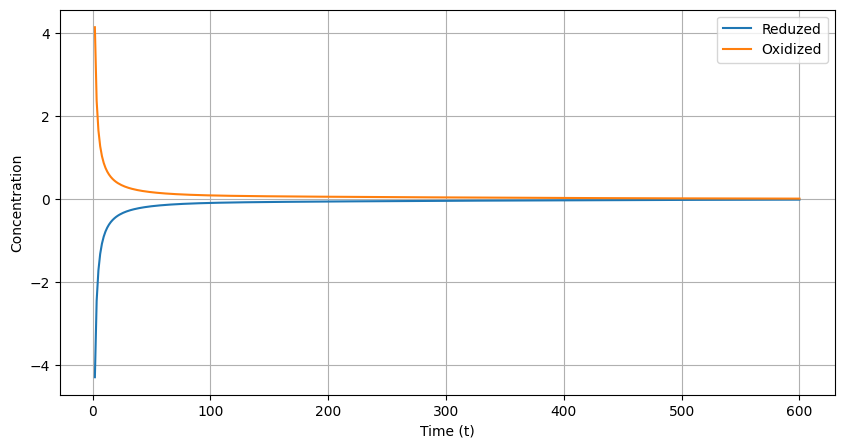

In [171]:
def CR_planar_Semi_inf(t,I,kp,k_p,kf,k_f, n,F,A,DO,DR,c):
    # Define s values for Laplace transform
    s_vals = np.logspace(-3, 3, len(t))  # Covers a wider range
    # Compute Laplace transform I(s)
    I_s = laplace_transform(I, t, s_vals)

    #
    def G(s):
        return ( (kp/k_p) / np.sqrt(s) + 1/np.sqrt(s + (kp+k_p)) )

    # Compute F(s) = I(s) * G(s)
    F_s = I_s * G(s_vals)

    # Define the function for Talbot method
    F_callable = lambda s: np.interp(s, s_vals, F_s)

    # Compute inverse Laplace transform
    inv_results = Talbot(F_callable, t,N=36)

    return (kp/k_p)*c/(1 +(kp/k_p) ) - inv_results/( (1 + (kp/k_p))*n*F*A*np.sqrt(DR)  )

def CO_planar_Semi_inf(t,I,kp,k_p,kf,k_f, n,F,A,DO,DR,c):
    # Define s values for Laplace transform
    s_vals = np.logspace(-3, 3, len(t))  # Covers a wider range
    # Compute Laplace transform I(s)
    I_s = laplace_transform(I, t, s_vals)
    #
    def Y(s):
        return (1 / np.sqrt(s) + (kf/k_f)/np.sqrt(s + (kf+k_f)) )

    # Compute F(s) = I(s) * G(s)
    F_s = I_s * Y(s_vals)

    # Define the function for Talbot method
    F_callable = lambda s: np.interp(s, s_vals, F_s)

    # Compute inverse Laplace transform
    inv_results = Talbot(F_callable, t,N=36)

    return inv_results/( (1 + ( kf/k_f) ) *n*F*A*np.sqrt(DO)   )


CR = CR_planar_Semi_inf(t,I,kp,k_p,kf,k_f,n,F,A,D,D,c*10**(-4) )

CO = CO_planar_Semi_inf(t,I,kp,k_p,kf,k_f,n,F,A,D,D,c*10**(-4))

# --- Plot Results ---
plt.figure(figsize=(10, 5))
plt.plot(t, CR, label="Reduzed")
plt.plot(t,CO , label='Oxidized')
plt.xlabel("Time (t)")
plt.ylabel("Concentration")
plt.legend()
plt.grid(True)
plt.show()

**Know apply it to real system**

To do it we need to have a finite electrode, so we need to define it

In [172]:
class Planar_Finite(CVCurrent):

    def __init__(self,**kwargs):
        super().__init__(**kwargs)

    def FuncG(self,t):

        GLaplace = lambda s: (np.cosh(self.d * np.sqrt(s/self.DR) ) / (np.sinh(self.d * np.sqrt(s/self.DR) ) ) )/np.sqrt(s+1e-10)*(1/(s+1e-10))

        #mp.dps = 12
        return Talbot(GLaplace, t , N=40)
    
    def FuncY(self,t):

        YLaplace = lambda s: (np.cosh(self.d * np.sqrt(s/self.DO) ) / (np.sinh(self.d * np.sqrt(s/self.DO) )  ) )/np.sqrt(s+1e-10)*(1/(s+1e-10))

        #mp.dps = 12
        Y =Talbot(YLaplace, t , N=40)

        return Y

In [ ]:
def generate_epsilon(scan_rate, E_start, E_peak, num_points):
    """
    Generates a triangular potential waveform for cyclic voltammetry.
    
    scan_rate: Rate of potential change (V/s)
    E_start: Initial potential (V)
    E_peak: Peak potential (V)
    num_points: Total number of points in the scan
    
    Returns:
        t: Time array
        epsilon: Potential array
    """
    # Half the time for forward and backward scans
    num_half = num_points // 2  

    # Time step based on scan rate
    t_up = np.linspace(1e-2, (E_peak - E_start) / scan_rate, num_half)  # Forward scan
    t_down = np.linspace(t_up[-1], 2 * t_up[-1], num_half)           # Reverse scan
    t = np.concatenate((t_up, t_down)).astype(np.longdouble)  # Full time array

    # Generate potential
    epsilon_up = E_start + scan_rate * t_up  # Forward potential
    epsilon_down = E_peak - scan_rate * (t_down - t_up[-1])  # Reverse potential
    epsilon = np.concatenate((epsilon_up, epsilon_down)).astype(np.longdouble)  # Full potential

    return t, epsilon


Define a new situation

0.019037955911823445


Text(0.5, 1.0, 'Curve the Potential will do')

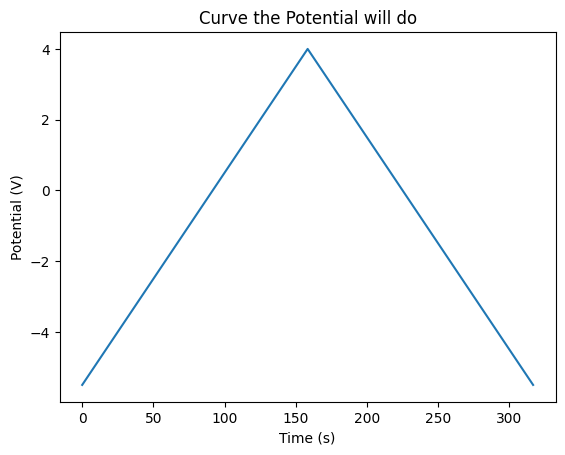

In [194]:
scan_rate = 60e-3  # Scan Rate (V/s)
E_start = -5.5  # Initial potential (V)
E_peak = 4    # Peak potential (V)
num_points = 1000  # Number of time steps

t, epsilon = generate_epsilon(scan_rate, E_start, E_peak, num_points)

epislon = epsilon*n*F/(R*T)
print(epsilon[1]-epsilon[0])

plt.plot(t,epsilon)
plt.xlabel("Time (s)")
plt.ylabel("Potential (V)")
plt.title("Curve the Potential will do")

Simulate

In [195]:
c = 0.16*10**(-4) #mol/L
A = 28 #cm^2
DR = 2.7e-5 #cm^2/s
DO = 3.2e-5 #cm^2/s
k0 = 2.6e-4 #cm^2/s
alpha = 0.42
kp = 0.0028#1e-4
k_p = 0.0028#kp/2
kf = 0.0008#1e-4
k_f = 0.0008#kf
km = 1e5
d = 200e-4

In [196]:
fp = Planar_Finite(d=d,c_tot=c,A=A,DR=DR,DO=DO,k0=k0,alpha=alpha,kp=kp,k_p=k_p,k_f=k_f,kf=kf,kmax=km)
I = fp(t, epsilon)

C:\Users\user\AppData\Local\Temp\ipykernel_21584\3296870034.py:8: RuntimeWarning: overflow encountered in cosh
  GLaplace = lambda s: (np.cosh(self.d * np.sqrt(s/self.DR) ) / (np.sinh(self.d * np.sqrt(s/self.DR) ) ) )/np.sqrt(s+1e-10)*(1/(s+1e-10))
C:\Users\user\AppData\Local\Temp\ipykernel_21584\3296870034.py:8: RuntimeWarning: overflow encountered in sinh
  GLaplace = lambda s: (np.cosh(self.d * np.sqrt(s/self.DR) ) / (np.sinh(self.d * np.sqrt(s/self.DR) ) ) )/np.sqrt(s+1e-10)*(1/(s+1e-10))
C:\Users\user\AppData\Local\Temp\ipykernel_21584\3296870034.py:8: RuntimeWarning: invalid value encountered in scalar divide
  GLaplace = lambda s: (np.cosh(self.d * np.sqrt(s/self.DR) ) / (np.sinh(self.d * np.sqrt(s/self.DR) ) ) )/np.sqrt(s+1e-10)*(1/(s+1e-10))
C:\Users\user\AppData\Local\Temp\ipykernel_21584\3296870034.py:15: RuntimeWarning: overflow encountered in cosh
  YLaplace = lambda s: (np.cosh(self.d * np.sqrt(s/self.DO) ) / (np.sinh(self.d * np.sqrt(s/self.DO) )  ) )/np.sqrt(s+1e-10)*(1

Show Simulation

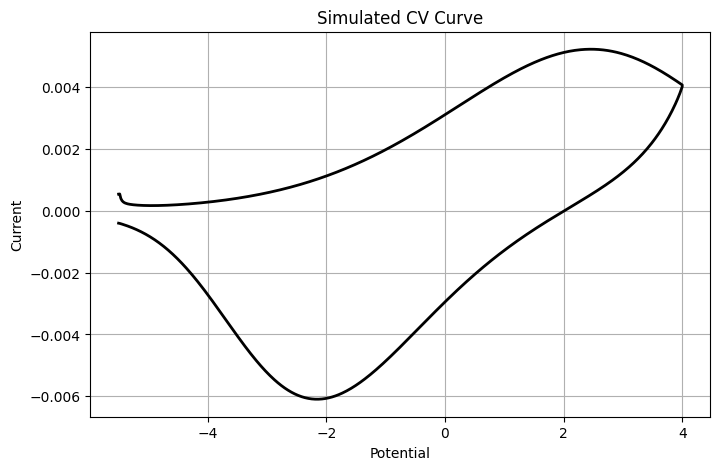

In [197]:
plt.figure(figsize=(8, 5))
plt.plot(epsilon, I , '-',color='black', linewidth=2)
plt.xlabel("Potential")
plt.ylabel("Current")
plt.title("Simulated CV Curve")
plt.grid(True)


plt.show()


In [215]:
def CR_planar_fin(t,I,kp,k_p,kf,k_f, n,F,A,DO,DR,c,d):
    Kp = kp/k_p
    p = kp+k_p


    s_vals = np.logspace(-5, 5, len(t))  # Covers a wider range
    # Compute Laplace transform I(s)
    I_s = laplace_transform(I, t, s_vals)

    def G(s):
        return ( Kp*(np.cosh(d * np.sqrt(s/DR) ) / (np.sinh(d * np.sqrt(s/DR) ) ) )/np.sqrt(s) + (np.cosh(d * np.sqrt((s+p)/DR) ) / (np.sinh(d * np.sqrt((s+p)/DR) ) ) )/np.sqrt(s+p) )

    # Compute F(s) = I(s) * G(s)
    F_s = I_s * G(s_vals)

    # Define the function for Talbot method
    F_callable = lambda s: np.interp(s, s_vals, F_s)

    # Compute inverse Laplace transform
    inv_results = Talbot(F_callable, t,N=56)

    return Kp*c/(1 + Kp ) - inv_results/( (1 + Kp )*n*F*A*np.sqrt(DR)  )

def CO_planar_fin(t,I,kp,k_p,kf,k_f, n,F,A,DO,DR,c,d):
    Kp = kp/k_p
    Kf = kf/k_f
    p = kp+k_p
    f = kf+k_f

    # Define s values for Laplace transform
    s_vals = np.logspace(-5, 5, len(t))  # Covers a wider range
    # Compute Laplace transform I(s)
    I_s = laplace_transform(I, t, s_vals)

    def Y(s):
        return ( (np.cosh(d * np.sqrt(s/DO) ) / (np.sinh(d * np.sqrt(s/DO) ) ) )/np.sqrt(s) + Kf*(np.cosh(d * np.sqrt((s+p)/DO) ) / (np.sinh(d * np.sqrt((s+p)/DO) ) ) )/np.sqrt(s+f) )

    # Compute F(s) = I(s) * G(s)
    F_s = I_s * Y(s_vals)

    # Define the function for Talbot method
    F_callable = lambda s: np.interp(s, s_vals, F_s)

    # Compute inverse Laplace transform
    inv_results = Talbot(F_callable, t,N=56)

    return inv_results/( (1 + Kf ) *n*F*A*np.sqrt(DO)   )


CR = CR_planar_fin(t,I,kp,k_p,kf,k_f,n,F,A,DO,DR,c,d)
CO = CO_planar_fin(t,I,kp,k_p,kf,k_f,n,F,A,DO,DR,c,d)


C:\Users\user\AppData\Local\Temp\ipykernel_21584\1151479526.py:11: RuntimeWarning: overflow encountered in cosh
  return ( Kp*(np.cosh(d * np.sqrt(s/DR) ) / (np.sinh(d * np.sqrt(s/DR) ) ) )/np.sqrt(s) + (np.cosh(d * np.sqrt((s+p)/DR) ) / (np.sinh(d * np.sqrt((s+p)/DR) ) ) )/np.sqrt(s+p) )
C:\Users\user\AppData\Local\Temp\ipykernel_21584\1151479526.py:11: RuntimeWarning: overflow encountered in sinh
  return ( Kp*(np.cosh(d * np.sqrt(s/DR) ) / (np.sinh(d * np.sqrt(s/DR) ) ) )/np.sqrt(s) + (np.cosh(d * np.sqrt((s+p)/DR) ) / (np.sinh(d * np.sqrt((s+p)/DR) ) ) )/np.sqrt(s+p) )
C:\Users\user\AppData\Local\Temp\ipykernel_21584\1151479526.py:11: RuntimeWarning: invalid value encountered in divide
  return ( Kp*(np.cosh(d * np.sqrt(s/DR) ) / (np.sinh(d * np.sqrt(s/DR) ) ) )/np.sqrt(s) + (np.cosh(d * np.sqrt((s+p)/DR) ) / (np.sinh(d * np.sqrt((s+p)/DR) ) ) )/np.sqrt(s+p) )
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1599: ComplexWarning: Ca

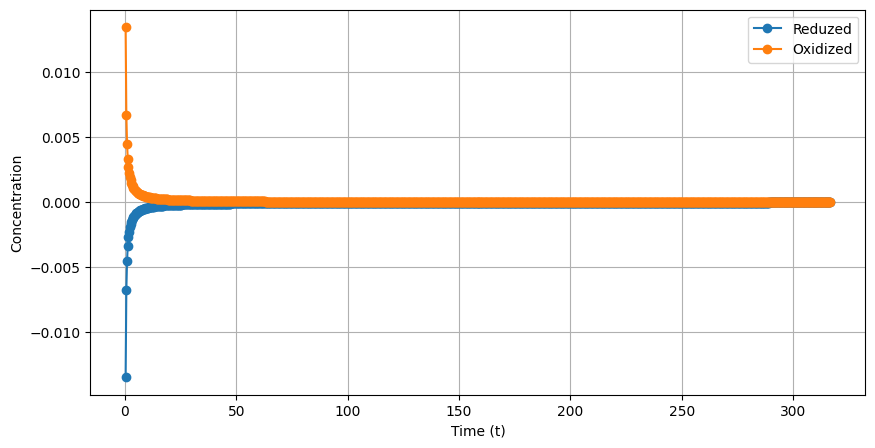

In [226]:
# --- Plot Results ---
plt.figure(figsize=(10, 5))
plt.plot(t[1:],(CR[1:]),'o-', label="Reduzed")
plt.plot(t[1:],(CO[1:]) , 'o-',label='Oxidized')
plt.xlabel("Time (t)")
plt.ylabel("Concentration")
plt.legend()
plt.grid(True)
#plt.yscale('log')
plt.show()

In [229]:
# Save the animation as an MP4 file
ani.save('animation.mp4', writer='ffmpeg', fps=30)


C:\Users\user\AppData\Local\Temp\ipykernel_21584\2143481837.py:27: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  scatter1.set_data(epsilon[frame], I[frame])
C:\Users\user\AppData\Local\Temp\ipykernel_21584\2143481837.py:30: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  scatter2.set_data(t[frame], CR[frame])
C:\Users\user\AppData\Local\Temp\ipykernel_21584\2143481837.py:33: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  scatter3.set_data(t[frame], CO[frame])


A lot more can be implemented, specially to define the case of an electrode with a sphere like geometry, allowing a good approximation to the expected when we have nanoparticles

In [54]:
class Sphere_Finite(CVCurrent):

    def __init__(self,**kwargs):
        super().__init__(**kwargs)

    def FuncG(self,t):

        GLaplace = lambda s: 1/(np.cosh(self.d * np.sqrt(s/self.DR) )/ (np.sinh(self.d * np.sqrt(s/self.DR) ) + 1e-10 )  * np.sqrt(s) - np.sqrt(self.DR)/self.d )*(1/s)

        return Talbot(GLaplace, t , N=24)
    
    def FuncY(self,t):

        YLaplace = lambda s: 1/(np.cosh(self.d * np.sqrt(s/self.DO) )/ (np.sinh(self.d * np.sqrt(s/self.DO) ) + 1e-10 )  * np.sqrt(s) - np.sqrt(self.DO)/self.d )*(1/s)

        Y =  Talbot(YLaplace, t , N=24)

        return Y

In [ ]:
fe = Sphere_Finite(d=d)
Ie = fe(t, epsilon)

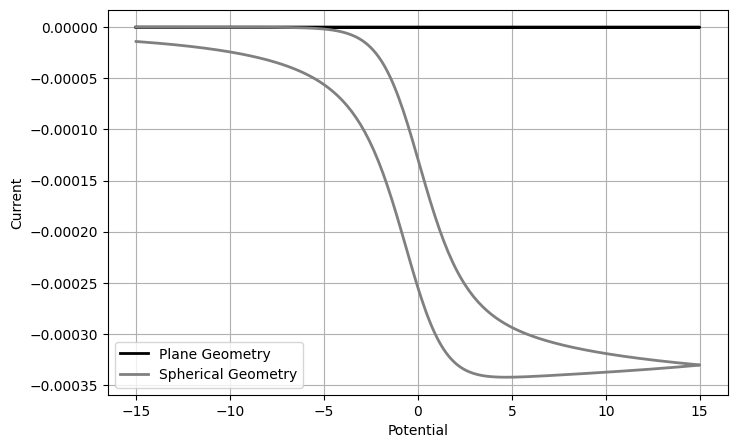

In [56]:
plt.figure(figsize=(8, 5))
plt.plot(epsilon, I , '-',color='black', linewidth=2 , label = 'Plane Geometry')
plt.plot(epsilon, Ie , '-',color='gray', linewidth=2 ,label = 'Spherical Geometry')
plt.xlabel("Potential")
plt.ylabel("Current")
plt.grid(True)

plt.legend()
plt.show()